--- 1. Fetching Crisis Data ---
Constructing Crisis Dataset (2008, 2018, 2020, 2022)...


/var/folders/04/4l6xjjw976j6gj89kg1qrrf80000gn/T/ipykernel_99931/1301014345.py:56: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(self.tickers, start=start, end=end, progress=False)
/var/folders/04/4l6xjjw976j6gj89kg1qrrf80000gn/T/ipykernel_99931/1301014345.py:56: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(self.tickers, start=start, end=end, progress=False)
/var/folders/04/4l6xjjw976j6gj89kg1qrrf80000gn/T/ipykernel_99931/1301014345.py:56: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(self.tickers, start=start, end=end, progress=False)
/var/folders/04/4l6xjjw976j6gj89kg1qrrf80000gn/T/ipykernel_99931/1301014345.py:56: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(self.tickers, start=start, end=end, progress=False)


Training Data Size: 806 rows (Stitched Crashes)
--- 2. Training Crisis Agent (PPO) ---
Using mps device


/opt/anaconda3/envs/ml/lib/python3.11/site-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


-----------------------------
| time/              |      |
|    fps             | 1038 |
|    iterations      | 1    |
|    time_elapsed    | 1    |
|    total_timesteps | 2048 |
-----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 672          |
|    iterations           | 2            |
|    time_elapsed         | 6            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0015949686 |
|    clip_fraction        | 0.0021       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.42        |
|    explained_variance   | 0.00383      |
|    learning_rate        | 0.0001       |
|    loss                 | 1.89e+03     |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.00239     |
|    std                  | 1            |
|    value_loss           | 3.6e+03      |
----------------

/var/folders/04/4l6xjjw976j6gj89kg1qrrf80000gn/T/ipykernel_99931/1301014345.py:56: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(self.tickers, start=start, end=end, progress=False)



CRISIS AGENT REPORT (Stress Test: COVID 2020)
Total Return         |      -4.13%
Max Drawdown         |     -12.15%
Final Balance        | $95,865.21


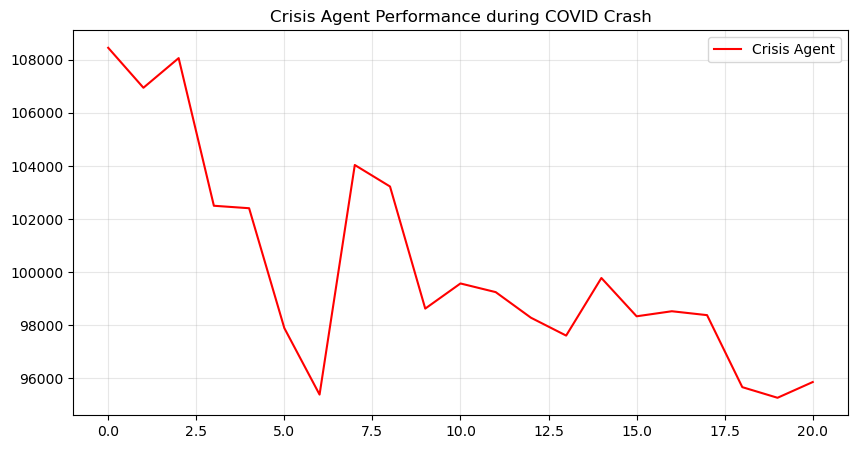

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import gymnasium as gym
from gymnasium import spaces
import torch
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
import matplotlib.pyplot as plt

# ==========================================
# 1. CONFIGURATION (CRISIS / HEDGE PROFILE)
# ==========================================
CONFIG = {
    # We trade SPY, but we look at VIX and Treasuries (SHY) for panic signals
    "TICKERS": ["SPY", "^VIX", "SHY"], 
    "TARGET_ASSET": "SPY",
    
    # "Frankenstein" Dataset: Train ONLY on historical crashes
    "CRISIS_PERIODS": [
        ("2007-08-01", "2009-06-01"), # 2008 Financial Crisis
        ("2018-10-01", "2019-01-01"), # 2018 Q4 Crash
        ("2020-01-01", "2020-05-01"), # COVID Crash
        ("2022-01-01", "2022-12-31"), # 2022 Inflation Bear
    ],
    "TEST_START_DATE": "2020-02-15", # Test on the specific COVID crash start
    "TEST_END_DATE": "2020-04-15",
    
    # Feature Engineering
    "WINDOW_SIZE": 5,          # Very short memory (Panic is immediate)
    
    # RL Environment
    "INITIAL_BALANCE": 100000,
    "TRADING_FEES": 0.001,     # Higher fees (assuming borrowing costs for shorting)
    "MAX_LEVERAGE": 1.0,
    
    # Reward: Capital Preservation Focus
    "REWARD_SCALING": 100.0,   
    
    # PPO Settings
    "LEARNING_RATE": 1e-4,     # Slower learning to avoid overfitting to noise
    "BATCH_SIZE": 128,
    "TRAINING_TIMESTEPS": 150000,
    "N_ENVS": 8
}

# ==========================================
# 2. CRISIS DATA PIPELINE (The "Frankenstein" Stitcher)
# ==========================================
class DataProcessor:
    def __init__(self, tickers):
        self.tickers = tickers
        
    def download_period(self, start, end):
        try:
            data = yf.download(self.tickers, start=start, end=end, progress=False)
            if data.empty: return pd.DataFrame()
            
            # Robust MultiIndex Handling
            if isinstance(data.columns, pd.MultiIndex):
                if 'Close' in data.columns.levels[0]:
                    data = data.xs('Close', level=0, axis=1)
                elif 'Adj Close' in data.columns.levels[0]:
                    data = data.xs('Adj Close', level=0, axis=1)
            if isinstance(data, pd.Series): data = data.to_frame()
            return data
        except:
            return pd.DataFrame()

    def get_training_data(self):
        """
        Stitches together multiple crash periods into one continuous 'nightmare' dataset.
        """
        print("Constructing Crisis Dataset (2008, 2018, 2020, 2022)...")
        df_list = []
        for start, end in CONFIG['CRISIS_PERIODS']:
            df = self.download_period(start, end)
            if not df.empty:
                df = self.add_indicators(df, CONFIG['TARGET_ASSET'])
                df_list.append(df)
        
        if not df_list: return pd.DataFrame()
        
        # Concatenate and reset index so the agent sees it as one long timeline
        combined_df = pd.concat(df_list, axis=0).reset_index(drop=True)
        
        # Select features
        features = ['returns', 'volatility', 'vix_level', 'flight_to_safety', 'rsi']
        return combined_df[features].fillna(0)

    def get_test_data(self):
        df = self.download_period(CONFIG['TEST_START_DATE'], CONFIG['TEST_END_DATE'])
        df = self.add_indicators(df, CONFIG['TARGET_ASSET'])
        features = ['returns', 'volatility', 'vix_level', 'flight_to_safety', 'rsi']
        return df[features].fillna(0)

    def add_indicators(self, df, target_ticker):
        if df.empty: return df
        df = df.copy()
        
        # 1. Returns
        df['returns'] = df[target_ticker].pct_change()
        
        # 2. VIX Level (Fear Gauge)
        if '^VIX' in df.columns:
            # Normalize VIX: >20 is high, >30 is panic. 
            # We scale it so 20 maps to ~0 and 80 maps to ~1 for the NN.
            df['vix_level'] = (df['^VIX'] - 15) / 40.0
        else:
            df['vix_level'] = 0
            
        # 3. Flight to Safety (Treasury vs Equity)
        # If SHY (Treasuries) is up and SPY is down, it's panic.
        if 'SHY' in df.columns:
            df['shy_ret'] = df['SHY'].pct_change()
            df['flight_to_safety'] = df['shy_ret'] - df['returns'] # Positive = Treasuries beating Stocks
        else:
            df['flight_to_safety'] = 0
            
        # 4. Volatility (Realized)
        df['volatility'] = df['returns'].rolling(10).std()
        
        # 5. RSI (Oversold bounce detector)
        # Even in crashes, we need to cover shorts on bounces.
        delta = df[target_ticker].diff()
        gain = (delta.where(delta > 0, 0)).rolling(14).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
        rs = gain / loss
        df['rsi'] = 100 - (100 / (1 + rs))

        df.dropna(inplace=True)
        return df

# ==========================================
# 3. CRISIS ENVIRONMENT (PARANOID MODE)
# ==========================================
class CrisisEnv(gym.Env):
    def __init__(self, df, config):
        super(CrisisEnv, self).__init__()
        self.data_matrix = df.values.astype(np.float32)
        self.config = config
        self.window_size = config['WINDOW_SIZE']
        self.data_len = len(df)
        
        # Action: [-1, 1]. 
        # -1 = Full Short, 0 = Cash, 1 = Full Long (Rarely used by this agent)
        self.action_space = spaces.Box(low=-1, high=1, shape=(1,), dtype=np.float32)
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, 
            shape=(self.window_size * df.shape[1],), 
            dtype=np.float32
        )
        
        self.current_step = self.window_size
        self.balance = config['INITIAL_BALANCE']
        self.portfolio_value = self.balance
        self.history = []
        self.peak_balance = self.balance # For drawdown calc

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.current_step = self.window_size
        self.balance = self.config['INITIAL_BALANCE']
        self.portfolio_value = self.balance
        self.peak_balance = self.balance
        self.history = []
        return self._get_observation(), {}

    def _get_observation(self):
        obs = self.data_matrix[self.current_step - self.window_size : self.current_step]
        return obs.flatten()

    def step(self, action):
        raw_action = np.clip(action, -1, 1)[0]
        
        # Force Bias: The agent is "allowed" to go long, but we don't scale it down.
        # It's trained on crashes, so it *should* naturally learn to be negative (Short).
        
        if self.current_step >= self.data_len:
            return self._get_observation(), 0, True, False, {}
            
        market_return = self.data_matrix[self.current_step, 0] # 0 is 'returns' index
        
        # Cost Calculation
        prev_action = self.history[-1]['action'] if len(self.history) > 0 else 0
        turnover = abs(raw_action - prev_action)
        cost = turnover * self.config['TRADING_FEES']
        
        # PnL logic: Shorting (negative action) profits from negative market_return
        strategy_return = (raw_action * market_return) - cost
        self.portfolio_value *= (1 + strategy_return)
        
        # --- REWARD: CALMAR-STYLE (Paranoid about Drawdown) ---
        
        # 1. Update Peak
        if self.portfolio_value > self.peak_balance:
            self.peak_balance = self.portfolio_value
            
        # 2. Calculate Drawdown %
        current_drawdown = (self.portfolio_value - self.peak_balance) / self.peak_balance
        
        # 3. Base Reward = PnL
        reward = strategy_return * self.config['REWARD_SCALING']
        
        # 4. Massive Drawdown Penalty
        # If drawdown is -5%, penalty is severe. This forces agent to go to Cash (Action 0)
        # rather than hold a losing Short or Long position.
        if current_drawdown < 0:
            reward += (current_drawdown * 20.0) # 20x penalty on drawdown depth
            
        # 5. Cash Incentive (Optional)
        # Small reward for staying in cash (Action ~ 0) to simulate "Risk Free Rate" safety
        if abs(raw_action) < 0.1:
            reward += 0.05

        self.current_step += 1
        terminated = self.current_step >= self.data_len - 1
        
        info = {
            'portfolio_value': self.portfolio_value,
            'return': strategy_return,
            'action': raw_action,
            'drawdown': current_drawdown
        }
        self.history.append(info)
        
        return self._get_observation(), reward, terminated, False, info

# ==========================================
# 4. EXECUTION
# ==========================================
def run_crisis_agent():
    print("--- 1. Fetching Crisis Data ---")
    dp = DataProcessor(CONFIG['TICKERS'])
    train_df = dp.get_training_data()
    
    if train_df.empty: 
        print("No data.")
        return

    print(f"Training Data Size: {len(train_df)} rows (Stitched Crashes)")

    print("--- 2. Training Crisis Agent (PPO) ---")
    # Parallel environments
    env = DummyVecEnv([lambda: CrisisEnv(train_df, CONFIG) for _ in range(CONFIG['N_ENVS'])])
    env = VecNormalize(env, norm_obs=True, norm_reward=False, clip_obs=10.)
    
    model = PPO(
        "MlpPolicy", 
        env, 
        verbose=1,
        learning_rate=CONFIG['LEARNING_RATE'],
        batch_size=CONFIG['BATCH_SIZE'],
        n_steps=2048 // CONFIG['N_ENVS'],
        device='mps'
    )
    
    model.learn(total_timesteps=CONFIG['TRAINING_TIMESTEPS'])
    
    print("--- 3. Stress Test: COVID Crash (Feb-Apr 2020) ---")
    test_df = dp.get_test_data()
    
    if test_df.empty: return

    test_env = DummyVecEnv([lambda: CrisisEnv(test_df, CONFIG)])
    test_env = VecNormalize(test_env, norm_obs=True, norm_reward=False, clip_obs=10.)
    test_env.obs_rms = env.obs_rms
    test_env.training = False
    
    obs = test_env.reset()
    history = []
    
    while True:
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, done_array, info_array = test_env.step(action)
        history.append(info_array[0])
        if done_array[0]: break
        
    # Analysis
    res = pd.DataFrame(history)
    total_ret = (res['portfolio_value'].iloc[-1] / CONFIG['INITIAL_BALANCE']) - 1
    mdd = res['drawdown'].min()
    
    print("\n" + "="*50)
    print(f"CRISIS AGENT REPORT (Stress Test: COVID 2020)")
    print("="*50)
    print(f"{'Total Return':<20} | {total_ret:>11.2%}")
    print(f"{'Max Drawdown':<20} | {mdd:>11.2%}")
    print(f"{'Final Balance':<20} | ${res['portfolio_value'].iloc[-1]:,.2f}")
    
    # Plot
    plt.figure(figsize=(10, 5))
    plt.plot(res['portfolio_value'], label='Crisis Agent', color='red')
    
    # Plot Benchmark (SPY) for comparison
    spy_bench = (1 + res['return']).cumprod() * CONFIG['INITIAL_BALANCE'] # Approx if fully invested
    # Actually, let's just plot the agent.
    
    plt.title("Crisis Agent Performance during COVID Crash")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

if __name__ == "__main__":
    run_crisis_agent()